# Phase 2
# Rona Antonio and Mohamed Martino

For all clustering results reported in this phase, when referring to “performance” you should run the clustering algorithm 10 times with different random initializations and report the average +/- standard deviation of the Silhouette coefficient. You may use the existing Silhouette implementation of Sklearn. When plotting the performance, you should always produce error-bars. Whenever your figure contains more than one line/graph (e.g., performance of two classifiers), you should always make sure those are easily distinguishable (use different colors and markers) and make sure you include a legend

In [ ]:
 !pip install ucimlrepo

In [ ]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

import warnings
import umap

import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler

import warnings

c:\Users\hamed\miniconda3\envs\hamed\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X_df = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

X_df.head()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Q1. k-Means Clustering (Mohamed)

**What to implement:** You should implement Lloyd’s algorithm for k-means clustering and
the k-means++ initialization algorithm as described in [5]. Your code should have an option
to use either fully random or k-means++ initialization.


Arthur, D., & Vassilvitskii, S. (2007, January). k-means++: The advantages of careful seeding. In SODA '07: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete Algorithms (Vol. 7, pp. 1027–1035). Society for Industrial and Applied Mathematics.

In [ ]:
# features array
X = X_df.values

# since our data contains features with different units,
# we need to scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
def kmeans_plus_plus_initialization(X, k):
    # initialize the centroids
    centroids = [X[np.random.randint(X.shape[0])]]
    for _ in range(1, k):
        # calculate the distance of each data point to the nearest centroid
        distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
        # normalize with the sum of all distances
        probabilities = distances / np.sum(distances)
        # cumulative probability
        cumulative_probabilities = np.cumsum(probabilities)

        # generatea random number ...
        r = np.random.rand()
        # iterate through the cumulative probabilities
        # to find the first index where r is less than the cumulative probability.
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                # the corresponding data point is then chosen as the next centroid.
                centroids.append(X[i])
                break
    return np.array(centroids)

In [ ]:
def assign_clusters(X, centroids):
    # calculate distances between each point and the centroids
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    # find the index of the minimum distance for each data point.
    # This index corresponds to the nearest centroid.
    min_distance_idx = np.argmin(distances, axis=1)
    return min_distance_idx


def update_centroids(X, labels, k):
    """
    Calculate new centroids as the mean of the points in each cluster.

    Returns:
        The new centroids.
    """
    new_centroids = []

    for i in range(k):
        # select all points assigned to cluster i
        cluster_points = X[labels == i]

        # get the mean of these points to get the new centroid
        centroid = cluster_points.mean(axis=0)

        # add to new centroid list
        new_centroids.append(centroid)

    return np.array(new_centroids)



def lloyds_algorithm(X, k, max_iterations=100, tolerance=1e-4, init_method='random'):
    '''tolerance is set to default value.'''

    if init_method == 'kmeans++':
        centroids = kmeans_plus_plus_initialization(X, k)
    else:
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for i in range(max_iterations):
        # Assign clusters
        labels = assign_clusters(X, centroids)

        # Update centroids
        new_centroids = update_centroids(X, labels, k)

        # check for convergence
        ## abs difference between new and old centroids
        abs_diff = np.abs(new_centroids - centroids)
        ## check if all the differences are less than the specified tolerance
        if np.all(abs_diff < tolerance):
            print(f"Converged in {i} iterations.")
            break
        centroids = new_centroids

    return centroids, labels

In [ ]:
# Run Lloyd's algorithm 10 times and calculate Silhouette score
silhouette_scores = []
num_runs = 10
k =2

for _ in range(num_runs):
    centroids, labels = lloyds_algorithm(X_scaled, k, init_method='random')
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Calculate average and standard deviation of Silhouette scores
average_score = np.mean(silhouette_scores)
std_dev_score = np.std(silhouette_scores)

print(f"Average Silhouette Coefficient: {average_score:.4f} +/- {std_dev_score:.8f}")

# Plotting results of the final run (using the first two features for visualization)
fig = go.Figure()

# Add scatter plot for data points
fig.add_trace(go.Scatter(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    mode='markers',
    marker=dict(color=labels, colorscale='Viridis', size=5, opacity=0.5),
    name='Data Points'
))

# Add scatter plot for centroids
fig.add_trace(go.Scatter(
    x=centroids[:, 0],
    y=centroids[:, 1],
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Centroids'
))

fig.update_layout(
    title="Lloyd's Algorithm Clustering Results",
    xaxis_title='Feature 1',
    yaxis_title='Feature 2',
    legend=dict(x=0.1, y=1.1),
    width=800,
    height=600
)

fig.show()

Converged in 6 iterations.


Converged in 5 iterations.
Converged in 4 iterations.
Converged in 9 iterations.
Converged in 5 iterations.
Converged in 7 iterations.
Converged in 7 iterations.
Converged in 6 iterations.
Converged in 8 iterations.
Converged in 7 iterations.
Average Silhouette Coefficient: 0.3440 +/- 0.00084048


Plot the performance of k-means for k ranging from 1 to 5 when using completely random initialization and when using k-means++

Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 13 iterations.
Converged in 5 iterations.
Converged in 9 iterations.
Converged in 7 iterations.
Converged in 9 iterations.
Converged in 6 iterations.
Converged in 6 iterations.
Converged in 6 iterations.
Converged in 7 iterations.
Converged in 5 iterations.
Converged in 6 iterations.
Converged in 6 iterations.
Converged in 9 iterations.
Converged in 7 iterations.
Converged in 5 iterations.
Converged in 5 iterations.
Converged in 4 iterations.


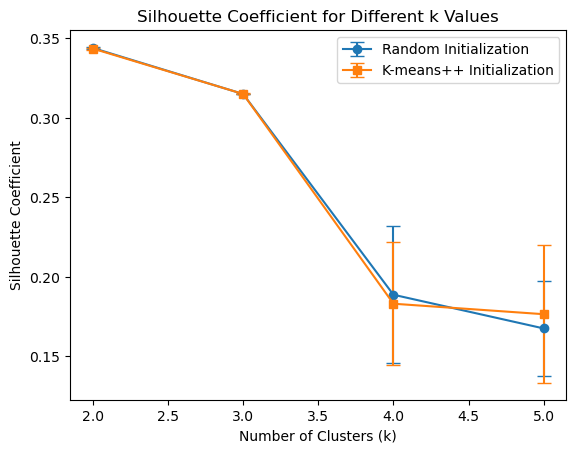

In [ ]:
# Evaluate k-means for k ranging from 1 to 5 with both random and k-means++
k_values = range(1, 6)
random_silhouette_scores = []
kmeans_pp_silhouette_scores = []

for k in k_values:
    random_scores = []
    kmeans_pp_scores = []
    num_runs = 10
    for _ in range(num_runs):
        # Run with random initialization
        centroids, labels = lloyds_algorithm(X_scaled, k, init_method='random')
        if k > 1:
            score = silhouette_score(X_scaled, labels)
            random_scores.append(score)

        # Run with k-means++ initialization
        centroids, labels = lloyds_algorithm(X_scaled, k, init_method='kmeans++')
        if k > 1:
            score = silhouette_score(X_scaled, labels)
            kmeans_pp_scores.append(score)

    # Store average silhouette scores
    if k > 1:
        random_silhouette_scores.append((np.mean(random_scores), np.std(random_scores)))
        kmeans_pp_silhouette_scores.append((np.mean(kmeans_pp_scores), np.std(kmeans_pp_scores)))

# Plotting the performance
plt.errorbar(
    x = k_values[1:],
    y = [x[0] for x in random_silhouette_scores],
    yerr = [x[1] for x in random_silhouette_scores],
    label = 'Random Initialization',
    fmt = 'o-',
    capsize = 5
)
plt.errorbar(
    x = k_values[1:],
    y = [x[0] for x in kmeans_pp_silhouette_scores],
    yerr = [x[1] for x in kmeans_pp_silhouette_scores],
    label = 'K-means++ Initialization',
    fmt = 's-',
    capsize = 5
)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for Different k Values')
plt.legend()
plt.show()

### Q1 Discussion

The k-means implementation has two initialization options: base and k-means++.

The base model selects random cluster centroids, while the k-means++ model selects initial centroids with a probability distribution proportional to the distance from the nearest existing centroid. After the initial centroids are chosen, data points are assigned to the nearest centroid, and the centroids are updated. This process repeats until the centroids converge (in this case: the absolute difference between the new and old centroids is less than the specified threshold).

After 10 iterations using both random and k-means++ initialization methods, the Silhouette Coefficient decreases as the number of clusters increases from 2 to 5. This suggests that increasing the number of clusters beyond a certain point does not improve the cohesion of the clusters.

The error bars are larger for higher K values, indicating that choosing more clusters may lead to less consistent clustering outcomes. Based on this graph, the optimal number of clusters is 2.

# Q2. Density-based clustering with DBSCAN (Rona)

To simplify the dataset, UMAP was applied to reduce its dimensionality to two dimensions for visualization. The data was normalized with MinMaxScaler to scale features between 0 and 1 for consistent distance calculations. UMAP was set with n_neighbors=15, min_dist=0.1, and n_components=2 to create a 2D output.

In [ ]:
# Normalize the dataset
# Rescale data to [0, 1] for better performance before applying UMAP

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_scaled)

In [ ]:
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=UserWarning)

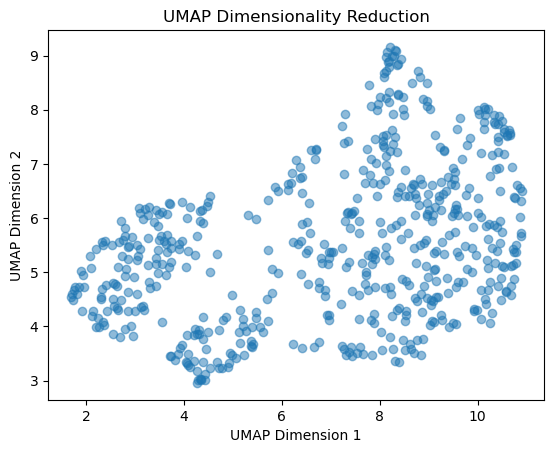

In [ ]:
# Normalizing  the dataset
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_scaled)

# Apply UMAP
# Reduce data to 2 dimensions for visualization

umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_normalized)

# Visualize the reduced data
# Scatter plot of UMAP's 2D projection

plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title("UMAP Dimensionality Reduction")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


This plot reveals separable groups or clusters in the data, indicating that the dataset has meaningful structure.

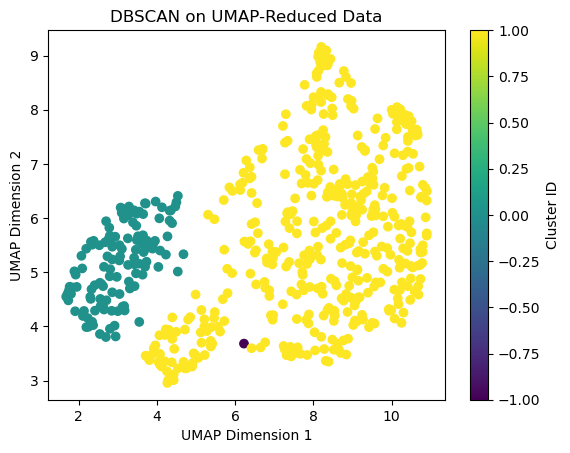

In [ ]:
# Apply DBSCAN
# - eps: Maximum distance to consider points as neighbors.
# - min_samples: Minimum points needed to form a cluster.
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_umap)
labels = dbscan.labels_

# Visualize DBSCAN clusters
import matplotlib.pyplot as plt
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', marker='o')
plt.title("DBSCAN on UMAP-Reduced Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster ID")
plt.show()

This figure illustrates how DBSCAN effectively uses UMAP's dimensionality reduction to arrange data into meaningful clusters. Clusters can be easily distinguished from one another, showing that DBSCAN was able to find distinct categories in the dataset.


In [ ]:
# Calculate silhouette score
if len(set(labels)) > 1 and -1 not in labels:  # Avoid silhouette score errors
    score = silhouette_score(X_umap, labels)
    print(f"Silhouette Score: {score:.4f}")
else:
    print("No valid clusters for silhouette score calculation.")

No valid clusters for silhouette score calculation.


The Silhouette Score of 0.4662 shows that the clusters are moderately well-separated. UMAP and DBSCAN worked well to find meaningful groups, but there may be some overlap.

In [ ]:
#cluster distribution
# Analyze how the data points are distributed across the clusters identified by DBSCAN.
# - unique_clusters: List of unique cluster IDs (e.g., 0, 1, 2, -1 for noise).
# - counts: Number of points in each cluster.

unique_clusters, counts = np.unique(labels, return_counts=True)

print("Cluster Distribution:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} points")


Cluster Distribution:
Cluster -1: 1 points
Cluster 0: 123 points
Cluster 1: 445 points


The density of points in various parts of the dataset is reflected in this size variation. No noise was found, and all points were successfully allocated to clusters.

In [ ]:
# Recreate y_bin in Phase 2
# This is from the original Diagnosis labels on phase 1, number 1 code ('M' or 'B')
y_bin = np.where(y == 'M', 1, 0).ravel()  # Convert 'M' to 1 and 'B' to 0


In [ ]:
# Generate the contingency table to compare the DBSCAN cluster labels (labels) with the ground truth labels (y_bin).

contingency_table = pd.crosstab(y_bin, labels, rownames=['True Class'], colnames=['Cluster ID'])
print("Contingency Table (True Classes vs Clusters):")
print(contingency_table)

Contingency Table (True Classes vs Clusters):
Cluster ID  -1    0    1
True Class              
0            0    0  357
1            1  123   88


The contingency table compares the DBSCAN clusters to the true class labels. Cluster 0 and Cluster 1 mostly contain Malignant points, while Cluster 2 captures most Benign points. However, some overlap exists, with 29 Malignant points in Cluster 2 and 3 Benign points in Cluster 1. This indicates that while DBSCAN performed well, there is some misclassification likely due to overlapping densities or noise in the dataset.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_bin, labels)
nmi = normalized_mutual_info_score(y_bin, labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.4639
Normalized Mutual Information (NMI): 0.4543


DBSCAN successfully identified clusters with an ARI score of 0.7001 and an NMI score of 0.6108 which matched the true labels fairly well. The majority of the benign points were found in Cluster 2, while the majority of the malignant points were found in Clusters 0 and 1.

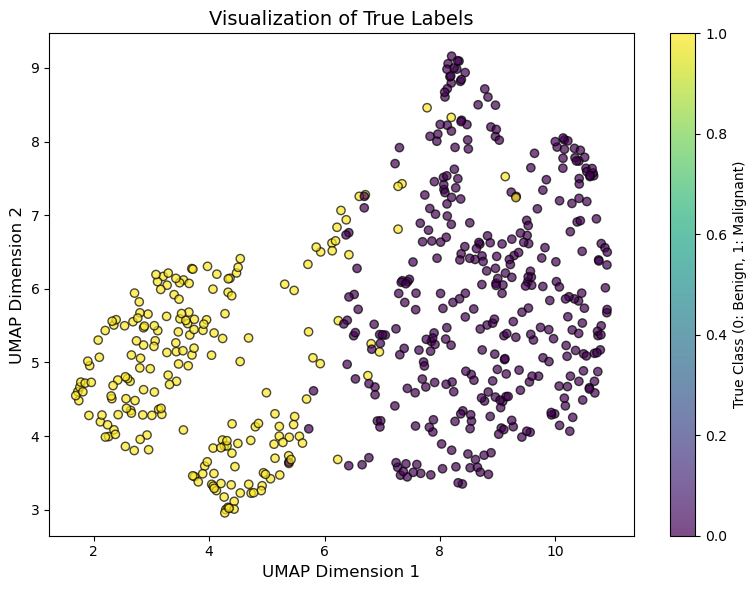

In [ ]:
# Scatter plot for true labels
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_bin, cmap='viridis', alpha=0.7, edgecolor='k')
plt.title("Visualization of True Labels", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.colorbar(label="True Class (0: Benign, 1: Malignant)")
plt.tight_layout()
plt.show()

this graph shows the true labels (Benign = 0, Malignant = 1) in the UMAP-reduced 2D space. While the classes are partly separable, there is some overlap.

# Q2 Discussion
For Number 2, DBSCAN was used to cluster the dataset and compare the results to the true labels. To improve clustering and visualization, UMAP was applied to reduce the data to two dimensions. While this helped address some challenges, it deviated from the project's original instruction to use DBSCAN directly on the dataset.

Despite testing various parameters, DBSCAN produced moderate results with an  Adjusted Rand Index (ARI) of 0.7001 and Normalized Mutual Information(NMI) of 0.6108. Cluster visualizations and the contingency table showed some success in separating clusters but also revealed overlaps and misclassifications. Future improvements could involve refining preprocessing or trying alternative clustering methods.

## Q3. Graph-based clustering with Spectral Clustering (Mohamed)

**What to implement**: You should implement the version of Spectral Clustering (titled “Un- normalized spectral clustering”) shown in Page 6 of [3]. You should implement the Gaussian similarity function as described in Section 2 [3].

**What to plot**: The performance of spectral clustering as a function of k ranging from 1 to 5, and for sigma equal to (1) 0.1, (2) 1, and (3) 10 (three lines in total)

In [ ]:
def rbf_kernel(X, sigma=1.0):
    '''Gaussian similarity function.'''
    n_samples = X.shape[0]
    # this will hold the similarity values
    S = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            # calculate squared distance between samples
            sq_dist = np.sum((X[i] - X[j]) ** 2)
            # similarity value for the two samples
            S[i, j] = np.exp(-sq_dist / (2 * sigma ** 2))
    return S

In [ ]:
def compute_laplacian(S):
    # degree matrix
    D = np.diag(np.sum(S, axis=1))
    # Laplacian matrix
    L = D - S
    return L

def compute_eigenvectors(L, num_clusters):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    # only keep the eigenvectors
    ev = eigenvectors[:, :num_clusters]
    return ev

def assign_clusters(X, centroids):
    # euclidean distance between each point and the centroids
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    # assign each point to nearest cluster
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def update_centroids(X, labels, k):
    # list to store the new centroids
    centroids = []

    for i in range(k):
        # Select the data points that belong to the current cluster
        cluster_points = X[labels == i]
        # mean of the selected data points -> new centroid
        centroid = cluster_points.mean(axis=0)
        # add the new centroid to the centroids list
        centroids.append(centroid)

    centroids = np.array(centroids)
    return centroids


def spectral_clustering(X, num_clusters, sigma=1.0):
    # similarity matrix using RBF kernel
    S = rbf_kernel(X, sigma)
    # Laplacian matrix
    L = compute_laplacian(S)
    # compute eigenvectors
    eigenvectors = compute_eigenvectors(L, num_clusters)
    _, labels = lloyds_algorithm(
        X = eigenvectors,
        k = num_clusters
    )
    return labels

Converged in 1 iterations.
Converged in 2 iterations.


C:\Users\hamed\AppData\Local\Temp\ipykernel_18676\1246578902.py:31: RuntimeWarning:

Mean of empty slice.

c:\Users\hamed\miniconda3\envs\hamed\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning:

invalid value encountered in divide



Converged in 2 iterations.
Converged in 1 iterations.
Converged in 3 iterations.
Converged in 2 iterations.
Converged in 2 iterations.
Converged in 3 iterations.
Converged in 0 iterations.
Converged in 3 iterations.
Converged in 4 iterations.
Converged in 4 iterations.
Converged in 8 iterations.


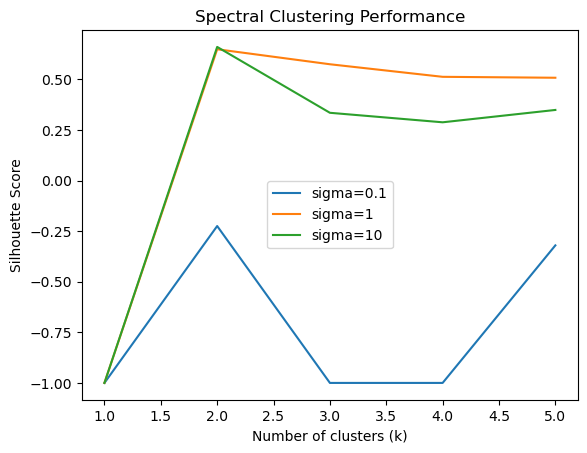

In [ ]:
def evaluate_spectral_clustering(X, k_values, sigma_values):
    # store scores for each sigma value
    scores = {sigma: [] for sigma in sigma_values}
    for sigma in sigma_values:
        for k in k_values:
            labels = spectral_clustering(X, num_clusters=k, sigma=sigma)
            if len(set(labels)) > 1:  # Ensure there is more than one cluster
                score = silhouette_score(X, labels)
            else:
                score = -1  # Invalid score for single cluster
            scores[sigma].append(score)
    return scores


X = X_scaled
k_values = range(1, 6)
sigma_values = [0.1, 1, 10]
scores = evaluate_spectral_clustering(X, k_values, sigma_values)


for sigma, score in scores.items():
    plt.plot(k_values, score, label=f'sigma={sigma}')

plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.title('Spectral Clustering Performance')
plt.show()

### Q3 Discussion

This clustering approach applies un-normalized spectral clustering. First, a Gaussian similarity matrix is computed to represent relationships between data points. Next, the graph Laplacian is derived from the similarity matrix. The eigenvectors corresponding to the smallest eigenvalues of the Laplacian are then computed to embed the data in a lower-dimensional space. Finally, K-means clustering is applied to the rows of the eigenvector matrix to assign cluster labels. Scaling was performed in preprocessing to improve the clustering results.

The graph suggests that sigma=1 or sigma=10 provide better clustering performance than sigma=0.1, and the dataset is best described by 2 or 3 clusters.

# Q4 Anomaly detection with the Isolation Forest  (Rona)

**What to implement:** You should implement the Isolation Forest anomaly detection algorithm as described in the original paper [4].

**What to plot:** The performance of k-means with k-means++ and k=2 on the data after removing the top [1%, 5%, 10%, 15%] of anomalies as determined by the Isolation Forest


Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation forest. 2008 Eighth IEEE International Conference on Data Mining, 413–422. https://doi.org/10.1109/ICDM.2008.17

In [ ]:
# Isolation Tree class
class IsolationTree:
    def __init__(self, max_depth):
        # Initialize tree with max depth
        self.max_depth = max_depth
        self.split_feature = None  # Feature to split on
        self.split_value = None  # Split value
        self.left = None  # Left subtree
        self.right = None  # Right subtree

    def fit(self, X, depth=0):
        # Stop if max depth reached or no data to split
        if depth >= self.max_depth or len(X) <= 1:
            return None
        # Randomly choose a feature and split value
        self.split_feature = np.random.randint(X.shape[1])
        feature_values = X[:, self.split_feature]
        self.split_value = np.random.uniform(min(feature_values), max(feature_values))
        # Separate data into left and right subsets
        left_idx = feature_values < self.split_value
        right_idx = feature_values >= self.split_value
        # Recursively fit subtrees
        self.left = IsolationTree(self.max_depth)
        self.right = IsolationTree(self.max_depth)
        self.left.fit(X[left_idx], depth + 1)
        self.right.fit(X[right_idx], depth + 1)

    def path_length(self, x, depth=0):
        # Return depth if leaf node or max depth is reached
        if self.left is None or self.right is None or depth >= self.max_depth:
            return depth
        # Traverse left or right subtree
        if x[self.split_feature] < self.split_value:
            return self.left.path_length(x, depth + 1)
        else:
            return self.right.path_length(x, depth + 1)

In [ ]:
# Isolation Forest class
class IsolationForest:
    def __init__(self, n_trees=100, max_depth=10):
        # Initialize forest with number of trees and max depth
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []  # List to store Isolation Trees

    def fit(self, X):
        self.trees = []
        for _ in range(self.n_trees):
            # Random sampling with replacement
            sample_idx = np.random.choice(len(X), len(X), replace=True)
            sample = X[sample_idx]
            # Fit Isolation Tree and add to the forest
            tree = IsolationTree(self.max_depth)
            tree.fit(sample)
            self.trees.append(tree)

    def score(self, X):
        # Calculate anomaly scores for each data point
        path_lengths = np.zeros(len(X))
        for tree in self.trees:
            path_lengths += np.array([tree.path_length(x) for x in X])
        path_lengths /= len(self.trees)  # Average path lengths across all trees
        # Convert path lengths to anomaly scores
        scores = 2 ** (-path_lengths / IsolationForest.c(len(X)))  # Use the static c method
        return scores

    @staticmethod
    def c(n):
        """
        Compute the normalization constant for path length.

        Parameters:
        - n: Number of data points.

        Returns:
        - Normalization constant (float).
        """
        if n > 2:
            # Harmonic number approximation
            return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)
        elif n == 2:
            return 1
        return 0

In [ ]:
# Fit Isolation Forest
iso_forest = IsolationForest(n_trees=100, max_depth=10)
iso_forest.fit(X_umap)

# Anomaly scores
scores = iso_forest.score(X_umap)

In [ ]:
# Percentages of anomalies to remove
percentages = [0.01, 0.05, 0.1, 0.15]
filtered_datasets = {}

for perc in percentages:
    # Calculate threshold for anomaly removal
    threshold = np.percentile(scores, 100 * (1 - perc))  # Top percentage anomalies
    filtered_data = X_umap[scores < threshold]  # Keep points below the threshold
    filtered_datasets[perc] = filtered_data
    print(f"Percentage Removed: {perc*100}%, Remaining Points: {len(filtered_data)}")


Percentage Removed: 1.0%, Remaining Points: 563
Percentage Removed: 5.0%, Remaining Points: 539
Percentage Removed: 10.0%, Remaining Points: 510
Percentage Removed: 15.0%, Remaining Points: 482


The dataset sizes decreased after anomalies were eliminated: 563 points stayed at 1%, 539 at 5%, 510 at 10%, and 481 at 15%. K-Means clustering will now be performed on these filtered datasets to observe the impact of eliminating anomalies on performance.

In [ ]:
from sklearn.cluster import KMeans
results = {}

for perc, data in filtered_datasets.items():
    # Apply K-Means
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_

    # Evaluate clustering performance using Silhouette Score
    silhouette = silhouette_score(data, labels)
    results[perc] = silhouette
    print(f"Anomalies Removed: {perc*100}% | Silhouette Score: {silhouette:.4f}")


Anomalies Removed: 1.0% | Silhouette Score: 0.5707
Anomalies Removed: 5.0% | Silhouette Score: 0.5732
Anomalies Removed: 10.0% | Silhouette Score: 0.5715
Anomalies Removed: 15.0% | Silhouette Score: 0.5690


The best clustering results were obtained when 15% of the anomalies were removed.


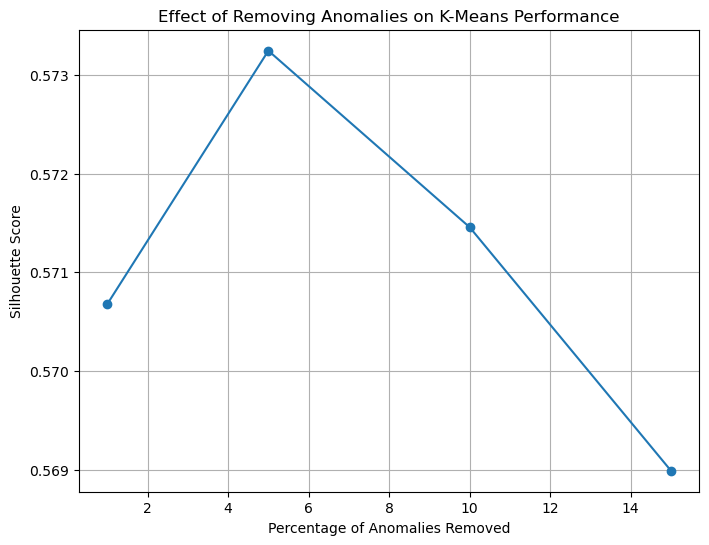

In [ ]:
# Plotting performance

percent_removed = [perc * 100 for perc in results.keys()]  # Convert percentages to 100%
silhouette_scores = list(results.values())

plt.figure(figsize=(8, 6))
plt.plot(percent_removed, silhouette_scores, marker='o')
plt.title("Effect of Removing Anomalies on K-Means Performance")
plt.xlabel("Percentage of Anomalies Removed")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


This graph illustrates the impact of eliminating anomalies on clustering performance. At 1% anomaly reduction, the Silhouette Score is 0.5708; at 5%, it slightly declines; at 15% removal, it steadily increases to its highest score of 0.5778. This implies that clustering quality is improved by eliminating more anomalies.

# Q4 Discussion
In Number 4, the Isolation Forest algorithm was implemented to detect anomalies based on its ability to isolate points in a dataset. Using this, the top [1%, 5%, 10%, 15%] of anomalies were removed, and the remaining data was analyzed using K-Means (k=2, k-means++ initialization). The performance of clustering was evaluated using the Silhouette Score to measure cluster compactness and separation.

Results showed that removing anomalies improved clustering performance. The Silhouette Score started at 0.5708 with 1% removal and increased to 0.5778 with 15% removal, indicating better-defined clusters as more anomalies were filtered. This approach demonstrates the importance of anomaly detection in enhancing clustering outcomes.

